# Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/Colab Notebooks/Challenge/Challenge_2

/gdrive/My Drive/Colab Notebooks/Challenge/Challenge_2


# Import libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


# Set seed for reproducibility

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#Data Augmentation:

We applied the data augmentation on the whole dataset and used Robust Scaler to scale our data:

In [119]:
x=np.load('x_train.npy') 
y=np.load('y_train.npy') 
 
from sklearn.model_selection import train_test_split 
import augmentation as aug 
from sklearn.preprocessing import RobustScaler, StandardScaler 
 
#Split data:
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.75, random_state=seed, stratify=y) 
 
#Augment data:
x_train_augmented = aug.time_warp(x_train) 
x_train = np.append(x_train, x_train_augmented, axis=0) 
 
y_train = np.append(y_train, y_train) 
 
print(x_train.shape) 
print(x_val.shape) 
print(y_train.shape) 
print(y_val.shape) 

#Scale the dataset:
scaler = RobustScaler() 
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape) 
x_val = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape) 
 
y_train_scalar = y_train 
y_val_scalar = y_val 
y_train = tfk.utils.to_categorical(y_train) 
y_val = tfk.utils.to_categorical(y_val) 
 
#Shape & Classes:
input_shape = x_train.shape[1:] 
classes = y_train.shape[-1]
batch_size = 32 
epochs = 200 

(3642, 36, 6)
(608, 36, 6)
(3642,)
(608,)


# ResNet-style Model with Conv1D layers

In [120]:
def build_model_resnet_1Dconv(input_shape, nb_classes):
        n_feature_maps = 64

        input_layer = tfkl.Input(input_shape)
        x1 = tfkl.GaussianNoise(stddev=0.2)(input_layer)

        # BLOCK 1

        conv_x = tfkl.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(x1)
        #conv_x = tfkl.BatchNormalization()(conv_x)
        conv_x = tfkl.Activation('relu')(conv_x)

        conv_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
        #conv_y = tfkl.BatchNormalization()(conv_y)
        conv_y = tfkl.Activation('relu')(conv_y)

        conv_z = tfkl.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
        #conv_z = tfkl.BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
        #shortcut_y = tfkl.BatchNormalization()(shortcut_y)

        output_block_1 = tfkl.add([shortcut_y, conv_z])
        output_block_1 = tfkl.Activation('relu')(output_block_1)

        # BLOCK 2

        conv_x = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
        #conv_x = tfkl.BatchNormalization()(conv_x)
        conv_x = tfkl.Activation('relu')(conv_x)

        conv_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        #conv_y = tfkl.BatchNormalization()(conv_y)
        conv_y = tfkl.Activation('relu')(conv_y)

        conv_z = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        #conv_z = tfkl.BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
        #shortcut_y = tfkl.BatchNormalization()(shortcut_y)

        output_block_2 = tfkl.add([shortcut_y, conv_z])
        output_block_2 = tfkl.Activation('relu')(output_block_2)

        # BLOCK 3

        conv_x = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
        #conv_x = tfkl.BatchNormalization()(conv_x)
        conv_x = tfkl.Activation('relu')(conv_x)

        conv_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        #conv_y = tfkl.BatchNormalization()(conv_y)
        conv_y = tfkl.Activation('relu')(conv_y)

        conv_z = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        #conv_z = tfkl.BatchNormalization()(conv_z)

        # no need to expand channels because they are equal
        #shortcut_y = tfkl.BatchNormalization()(output_block_2)

        output_block_3 = tfkl.add([shortcut_y, conv_z])
        output_block_3 = tfkl.Activation('relu')(output_block_3)

        # FINAL

        gap_layer = tfkl.GlobalAveragePooling1D()(output_block_3)

        output_layer = tfkl.Dense(nb_classes, activation='softmax')(gap_layer)

        model = tfk.Model(inputs=input_layer, outputs=output_layer)

        model.compile(loss='categorical_crossentropy' , optimizer=tfk.optimizers.Adam(),
                      metrics=['accuracy'])

        return model 

In [122]:
model_resnet=build_model_resnet_1Dconv(input_shape,classes)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-88l1rll0
  Running command git clone -q https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-88l1rll0


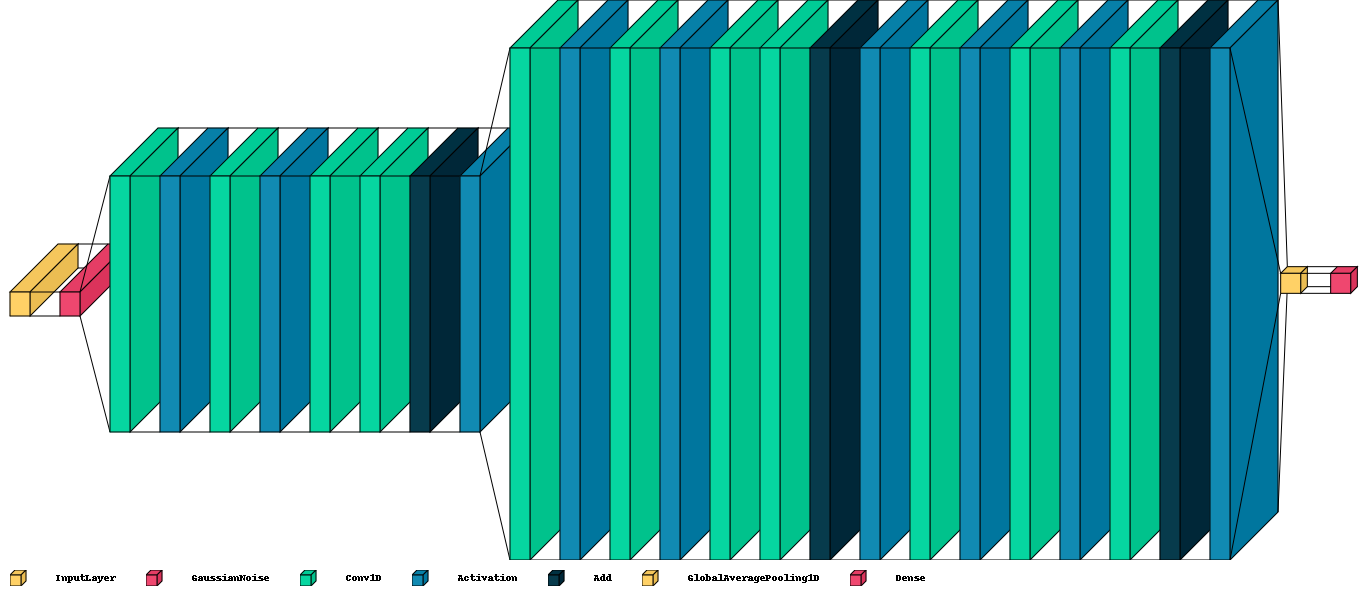

In [127]:
#visualize model and plot model

!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade
import visualkeras

from keras.utils.vis_utils import plot_model

plot_model(model_resnet)

visualkeras.layered_view(model_resnet, legend=True,draw_volume=True,spacing=30)

In [123]:
# Train the model 
history_resnet = model_resnet.fit( 
    x = x_train, 
    y = y_train, 
    batch_size = 32, 
    epochs = 200, 
    validation_data=(x_val,y_val), 
    callbacks = [ 
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True), 
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=7, factor=0.5, min_lr=1e-5) 
    ] 
).history

Epoch 1/200
114/114 [==============================] - 18s 150ms/step - loss: 2.5707 - accuracy: 0.3723 - val_loss: 1.8517 - val_accuracy: 0.4293 - lr: 0.0010
Epoch 2/200
114/114 [==============================] - 15s 129ms/step - loss: 1.7855 - accuracy: 0.4698 - val_loss: 1.7146 - val_accuracy: 0.4737 - lr: 0.0010
Epoch 3/200
114/114 [==============================] - 16s 142ms/step - loss: 1.6878 - accuracy: 0.5011 - val_loss: 1.6066 - val_accuracy: 0.4934 - lr: 0.0010
Epoch 4/200
114/114 [==============================] - 13s 116ms/step - loss: 1.5603 - accuracy: 0.5030 - val_loss: 1.3607 - val_accuracy: 0.5740 - lr: 0.0010
Epoch 5/200
114/114 [==============================] - 13s 117ms/step - loss: 1.4677 - accuracy: 0.5329 - val_loss: 1.7260 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 6/200
114/114 [==============================] - 17s 149ms/step - loss: 1.2744 - accuracy: 0.5785 - val_loss: 1.2333 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 7/200
114/114 [=========================

In [125]:
epoca=np.argmax(history_resnet['val_accuracy'])
v_acc=np.max(history_resnet['val_accuracy'])
epoca,v_acc

(37, 0.7467105388641357)

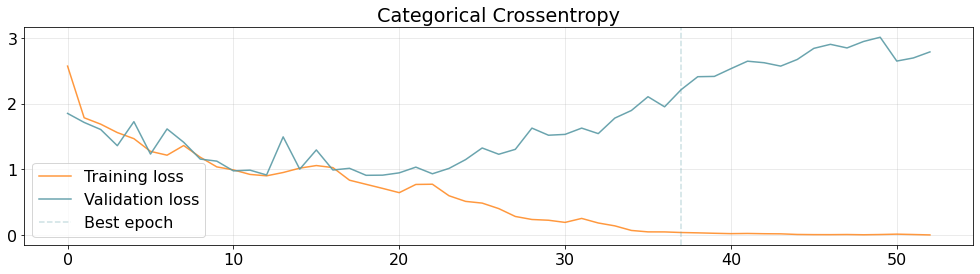

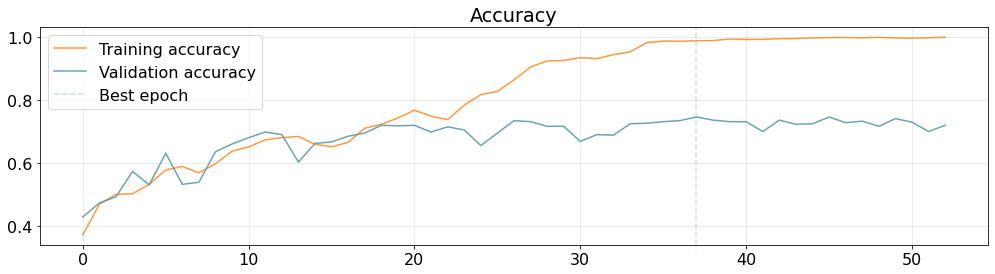

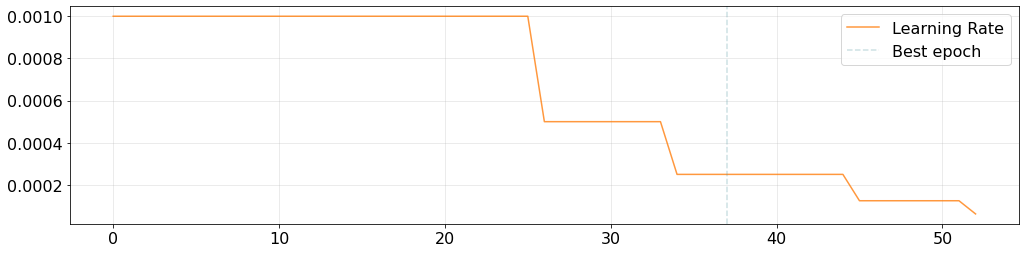

In [132]:
best_epoch = np.argmax(history_resnet['val_accuracy']) 
fig = plt.figure(figsize=(17,4)) 
plt.plot(history_resnet['loss'], label='Training loss', alpha=.8, color='#ff7f0e') 
plt.plot(history_resnet['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5') 
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5') 
plt.title('Categorical Crossentropy') 
plt.legend() 
plt.grid(alpha=.3) 
plt.show() 
fig.savefig(os.path.join(dir, 'cat_loss_train_val.pdf'), bbox_inches='tight') 
 
 
fig = plt.figure(figsize=(17,4)) 
plt.plot(history_resnet['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e') 
plt.plot(history_resnet['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5') 
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5') 
plt.title('Accuracy') 
plt.legend() 
plt.grid(alpha=.3) 
plt.show() 
fig.savefig(os.path.join(dir, 'accuracy_train_val.pdf'), bbox_inches='tight') 
 
 
plt.figure(figsize=(17,4)) 
plt.plot(history_resnet['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e') 
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5') 
plt.legend() 
plt.grid(alpha=.3) 
plt.show() 

19/19 [==============================] - 1s 72ms/step


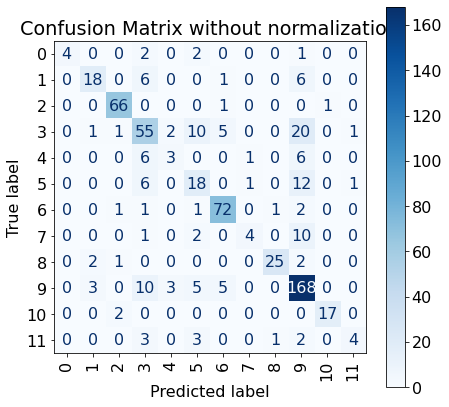

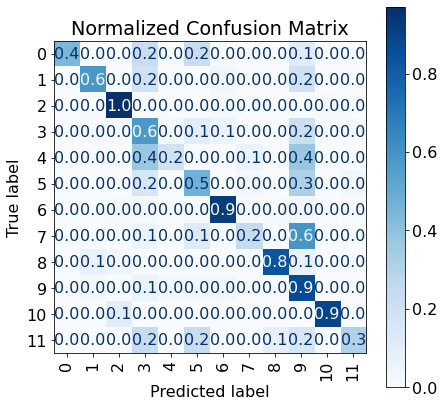

In [138]:
#Confusion matrix

from tqdm import tqdm

predictions = model_resnet.predict(x_val)
y_pred = np.argmax(predictions, axis= -1)
labels =  np.unique(y_val_scalar)


confusion_matrix = tf.math.confusion_matrix(y_val_scalar,y_pred).numpy()

dir = os.getcwd()

from sklearn.metrics import ConfusionMatrixDisplay


fig, ax = plt.subplots(figsize=(7,7))
disp = ConfusionMatrixDisplay(confusion_matrix, display_labels=labels)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='d',cmap='Blues')
plt.title("Confusion Matrix without normalization")
fig_name=os.path.join(dir, 'pdf_matrix/myConfusionMatrix.jpeg')
plt.show()


from sklearn.metrics import ConfusionMatrixDisplay


fig, ax = plt.subplots(figsize=(7,7))
cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(cmn, display_labels=labels)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.1f',cmap='Blues')
plt.title("Normalized Confusion Matrix")
fig_name=os.path.join(dir, 'pdf_matrix/myConfusionMatrix_normalized.jpeg')
plt.show()


In [133]:
model_resnet.save('ResNet_attempt')

# A few other attempts

Below are listed our other attempts regarding the preprocessing of the data and the building of the models

## Dataset Loading

We unzip the dataset to be used for timeseries classification:

In [ ]:
# Load the dataset to be used for classification
#!unzip training_dataset_homework2.zip

In [5]:
x_train=np.load('x_train.npy')
x_train.shape

(2429, 36, 6)

In [9]:
y_train=np.load('y_train.npy')
y_train.shape

(2429,)

In [11]:
y_train = tfk.utils.to_categorical(y_train)
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [10]:
# Inspect activities timestamps: Label & Frequency
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0  34]
 [  1 123]
 [  2 270]
 [  3 381]
 [  4  62]
 [  5 153]
 [  6 313]
 [  7  68]
 [  8 120]
 [  9 777]
 [ 10  77]
 [ 11  51]]


In [12]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

##Preprocessing:

 ### Feature Reduction

We look for the correlation between features. In order to do that, we first reshape the three dimensional array into a lower one:

In [110]:
x_train_temp = x_train.reshape(-1,x_train.shape[-1])
pd.DataFrame(x_train_temp).corr(method='pearson')

,0,1,2,3,4,5
0,1.000000,0.270794,0.301492,0.293283,0.259445,0.253504
1,0.270794,1.000000,0.474895,0.438932,0.356807,0.327389
2,0.301492,0.474895,1.000000,0.612204,0.515992,0.459227
3,0.293283,0.438932,0.612204,1.000000,0.564847,0.490825
4,0.259445,0.356807,0.515992,0.564847,1.000000,0.700274
5,0.253504,0.327389,0.459227,0.490825,0.700274,1.000000


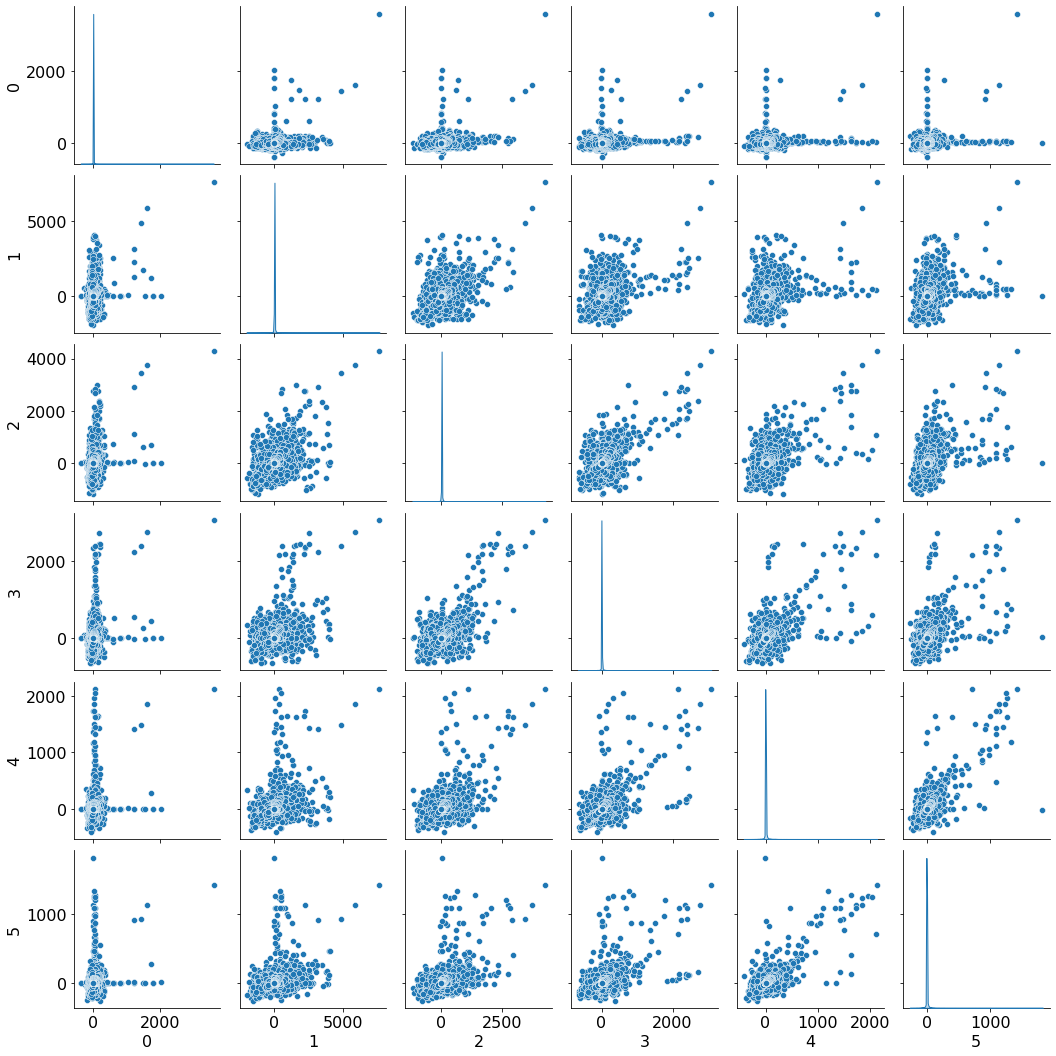

In [ ]:
sns.pairplot(pd.DataFrame(x_train_temp), diag_kind='kde')

Since featyre 4 and 5 are highly correlated we delete feature 4:


In [111]:
x_train_red=x_train.reshape(-1,x_train.shape[-1])
x_train_red=np.delete(x_train_red, 4, 1)

In [112]:
pd.DataFrame(x_train_red).corr(method='pearson')

,0,1,2,3,4
0,1.000000,0.270794,0.301492,0.293283,0.253504
1,0.270794,1.000000,0.474895,0.438932,0.327389
2,0.301492,0.474895,1.000000,0.612204,0.459227
3,0.293283,0.438932,0.612204,1.000000,0.490825
4,0.253504,0.327389,0.459227,0.490825,1.000000


Since feature 2 and 3 are moderate positive correlated we delete feature 3:

In [113]:
x_train_red=np.delete(x_train_red, 3, 1)
x_train_red

array([[ 17.597  ,   8.1713 ,  -1.7842 , -61.887  ],
       [  0.22974,  -5.8956 ,  16.837  ,  58.914  ],
       [-29.654  , -21.296  ,  29.103  ,  10.665  ],
       ...,
       [  0.20638,   1.0287 ,  -0.92512,   4.7638 ],
       [  4.1429 ,   1.0939 ,  -0.18921,   4.1742 ],
       [ -1.5545 ,  -1.2121 ,   1.0705 ,   8.455  ]])

In [114]:
pd.DataFrame(x_train_red).corr(method='pearson')

,0,1,2,3
0,1.000000,0.270794,0.301492,0.253504
1,0.270794,1.000000,0.474895,0.327389
2,0.301492,0.474895,1.000000,0.459227
3,0.253504,0.327389,0.459227,1.000000


We then rescale the reduced dataset using RobustScaler:

In [116]:
import torch
transformer = RobustScaler()
transformer = transformer.fit(x_train_red)
x_train_red=transformer.transform(x_train_red)
x_train_red = x_train_red.reshape(x_train.shape[0], x_train.shape[1],4)
x_train_red

array([[[ 1.89438350e+00,  1.33331959e+00, -2.82069896e-01,
         -2.19227851e+00],
        [-5.00623387e-03, -1.08348667e+00,  1.87387275e+00,
          1.94561355e+00],
        [-3.27327475e+00, -3.72939893e+00,  3.29401712e+00,
          2.92902443e-01],
        ...,
        [ 1.30741158e+01,  3.74677594e+01,  1.89778795e+02,
          5.60732826e-01],
        [ 9.98681974e+00,  1.77596612e+01,  2.11082119e+02,
          2.56545796e+01],
        [ 4.75124513e+00,  5.20204108e+00,  1.10021005e+02,
          3.37987607e+01]],

       [[ 2.34632420e-01, -1.66854796e-01,  2.66313772e+00,
          2.10213795e-01],
        [ 1.54117087e-01,  4.05092733e+00,  1.98571520e+00,
         -8.93100773e-01],
        [ 2.53078656e-02,  8.56810384e+00,  5.85192106e+00,
         -6.95319391e-01],
        ...,
        [-1.73821197e+00, -1.34595779e+00,  3.62529307e-01,
         -2.61594480e-01],
        [-1.20056816e+00, -1.16272453e+00, -6.13452354e-01,
          5.80805546e-01],
        [-5.370

In [ ]:
import pickle

# save the model to disk
filename = 'qualcosa_transformer_reduceddataset.sav'
pickle.dump(transformer, open(filename, 'wb'))

In [ ]:
from sklearn.model_selection import train_test_split
x_train_real_red, x_val_real_red, y_train_real_red, y_val_real_red = train_test_split(x_train_red, y_train, test_size=0.2, random_state=seed,stratify=y_train)

### Scalers

We scale the dataset using different tecnhiques on different dimensions:

Z-score:

In [ ]:
#from scipy import stats
#x_train2=stats.zscore(x_train)
#x_train2

In [ ]:
#x_train3=x_train
#for num in range(x_train.shape[0]):
#  x_train3[num]=stats.zscore(x_train[num])
#x_train3

MinMaxScaler:

In [ ]:
#from sklearn.preprocessing import MinMaxScaler

#x_train7=x_train
#for num in range(x_train.shape[0]):
#  transformer = MinMaxScaler().fit(x_train7[num])
#  x_train7[num]=transformer.transform(x_train7[num])
#x_train7

Standard Scaler:

In [ ]:
# importing torch module
#import torch
#from sklearn.preprocessing import StandardScaler
#x_train9 = x_train.reshape(-1,x_train.shape[-1])
#transformer =  ()
#transformer = transformer.fit(x_train9)
#mean, scale = transformer.center_, transformer.scale_
#x_train9=transformer.transform(x_train9)
#x_train9 = x_train8.reshape(x_train.shape)
#x_train9

RobustScaler:

In [13]:
#Robust scaler for each time series:
from sklearn.preprocessing import RobustScaler

#x_train6=x_train
#for num in range(x_train.shape[0]):
#  transformer = RobustScaler().fit(x_train6[num])
#  x_train6[num]=transformer.transform(x_train6[num])
#x_train6

In [ ]:
#Robust scaler applied to the whole dataset:
import torch
from sklearn.preprocessing import RobustScaler

x_train8 = x_train.reshape(-1,x_train.shape[-1])
transformer = RobustScaler()
transformer = transformer.fit(x_train8)
x_train8=transformer.transform(x_train8)
x_train8 = x_train8.reshape(x_train.shape)
x_train8


array([[[ 1.89438350e+00,  1.33331959e+00, -2.82069896e-01,
         -1.66581051e+00, -6.06523843e-01, -2.19227851e+00],
        [-5.00623387e-03, -1.08348667e+00,  1.87387275e+00,
          3.30329510e-01,  6.32121324e-02,  1.94561355e+00],
        [-3.27327475e+00, -3.72939893e+00,  3.29401712e+00,
         -1.14478569e-01,  4.08590664e+00,  2.92902443e-01],
        ...,
        [ 1.30741158e+01,  3.74677594e+01,  1.89778795e+02,
          4.81530687e+01,  1.20800993e+02,  5.60732826e-01],
        [ 9.98681974e+00,  1.77596612e+01,  2.11082119e+02,
          1.00436691e+02,  6.23035431e+02,  2.56545796e+01],
        [ 4.75124513e+00,  5.20204108e+00,  1.10021005e+02,
          6.92397933e+01,  4.48366048e+02,  3.37987607e+01]],

       [[ 2.34632420e-01, -1.66854796e-01,  2.66313772e+00,
         -3.84078071e-01,  4.70596668e-03,  2.10213795e-01],
        [ 1.54117087e-01,  4.05092733e+00,  1.98571520e+00,
         -1.65524294e+00, -5.26017903e-01, -8.93100773e-01],
        [ 2.53078

In [ ]:
import pickle

# save the model to disk
filename = 'qualcosa_transformer.sav'
pickle.dump(transformer, open(filename, 'wb'))

In order to proceed with the analysis we decide to split the given dataset into two sets, one for training and one for validation, corresponding respectively to 80%-20% of the whole dataset.

In [ ]:
from sklearn.model_selection import train_test_split
x_train_real, x_val_real, y_train_real, y_val_real = train_test_split(x_train8, y_train, test_size=0.2, random_state=seed,stratify=y_train)

## Build and train models

Here are listed a few attempts of architecture we have tried, with their history, their validation accuracy on the best epoch and the plot of their Categorical Crossentropy and Accuracy.

#### Vanilla Long Short Term Memory (LSTM) Neural Network

In [18]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [19]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 36, 128)           69120     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 12)                1548      
                                                                 
Total params: 218,764
Trainable params: 218,764
Non-trainable

In [20]:
history = model.fit( 
    x = x_train_real,  
    y = y_train_real,
    batch_size = 32,
    epochs = 200,
    validation_data=(x_val_real,y_val_real),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=7, factor=0.5, min_lr=1e-6)
    ]
).history


Epoch 1/200
61/61 [==============================] - 15s 153ms/step - loss: 1.8758 - accuracy: 0.3896 - val_loss: 1.4542 - val_accuracy: 0.5103 - lr: 0.0010
Epoch 2/200
61/61 [==============================] - 8s 133ms/step - loss: 1.4083 - accuracy: 0.5188 - val_loss: 1.3029 - val_accuracy: 0.5864 - lr: 0.0010
Epoch 3/200
61/61 [==============================] - 8s 135ms/step - loss: 1.2545 - accuracy: 0.5692 - val_loss: 1.1891 - val_accuracy: 0.5885 - lr: 0.0010
Epoch 4/200
61/61 [==============================] - 8s 136ms/step - loss: 1.1496 - accuracy: 0.6011 - val_loss: 1.2181 - val_accuracy: 0.5905 - lr: 0.0010
Epoch 5/200
61/61 [==============================] - 8s 131ms/step - loss: 1.1019 - accuracy: 0.6274 - val_loss: 1.1694 - val_accuracy: 0.5802 - lr: 0.0010
Epoch 6/200
61/61 [==============================] - 8s 132ms/step - loss: 1.0457 - accuracy: 0.6526 - val_loss: 1.1011 - val_accuracy: 0.6358 - lr: 0.0010
Epoch 7/200
61/61 [==============================] - 8s 130ms/s

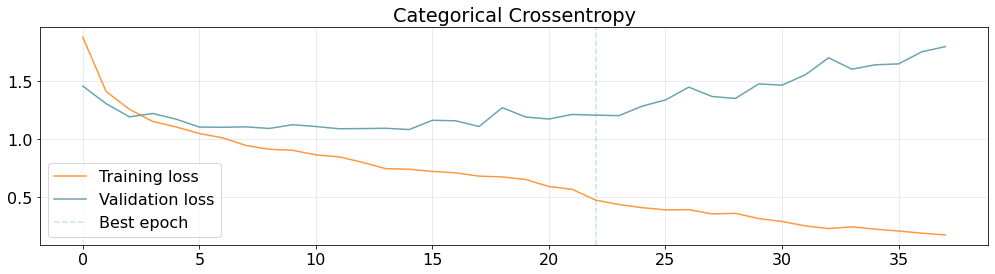

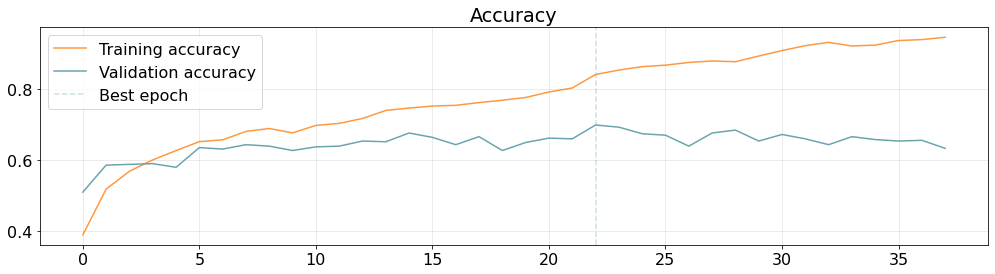

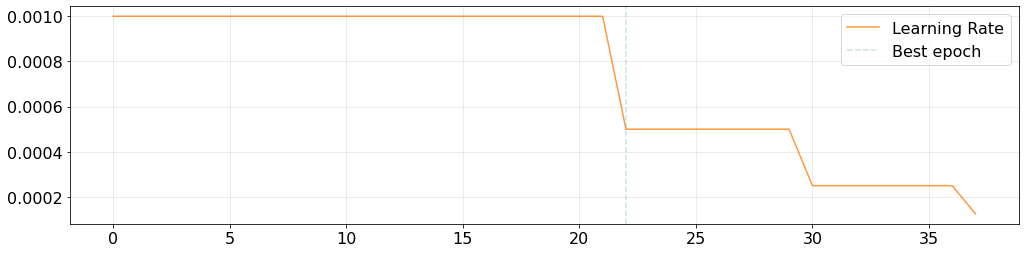

In [21]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [23]:
epoca=np.argmax(history['val_accuracy'])
v_acc=np.max(history['val_accuracy'])
epoca,v_acc

(22, 0.6995884776115417)

In [22]:
model.save('LSTM_attempt')

#### Bidirectional Long Short Term Memory (BiLSTM) Neural Network

In [24]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [25]:
model1 = build_BiLSTM_classifier(input_shape, classes)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 36, 256)          138240    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 12)                1548  

In [26]:
# Train the model
history1 = model1.fit( 
    x = x_train_real,  
    y = y_train_real,
    batch_size = 32,
    epochs = 200,
    validation_data=(x_val_real,y_val_real),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=7, factor=0.5, min_lr=1e-6)
    ]
).history

Epoch 1/200
61/61 [==============================] - 28s 315ms/step - loss: 1.7338 - accuracy: 0.4277 - val_loss: 1.3850 - val_accuracy: 0.4877 - lr: 0.0010
Epoch 2/200
61/61 [==============================] - 22s 356ms/step - loss: 1.2682 - accuracy: 0.5625 - val_loss: 1.2630 - val_accuracy: 0.6091 - lr: 0.0010
Epoch 3/200
61/61 [==============================] - 21s 351ms/step - loss: 1.1383 - accuracy: 0.6011 - val_loss: 1.2013 - val_accuracy: 0.5926 - lr: 0.0010
Epoch 4/200
61/61 [==============================] - 28s 461ms/step - loss: 1.0497 - accuracy: 0.6387 - val_loss: 1.0997 - val_accuracy: 0.6440 - lr: 0.0010
Epoch 5/200
61/61 [==============================] - 25s 412ms/step - loss: 0.9666 - accuracy: 0.6624 - val_loss: 1.1157 - val_accuracy: 0.6173 - lr: 0.0010
Epoch 6/200
61/61 [==============================] - 19s 316ms/step - loss: 0.8866 - accuracy: 0.6871 - val_loss: 1.0632 - val_accuracy: 0.6502 - lr: 0.0010
Epoch 7/200
61/61 [==============================] - 19s 3

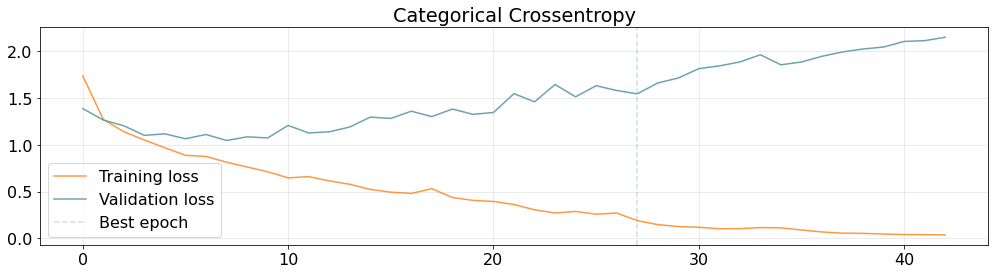

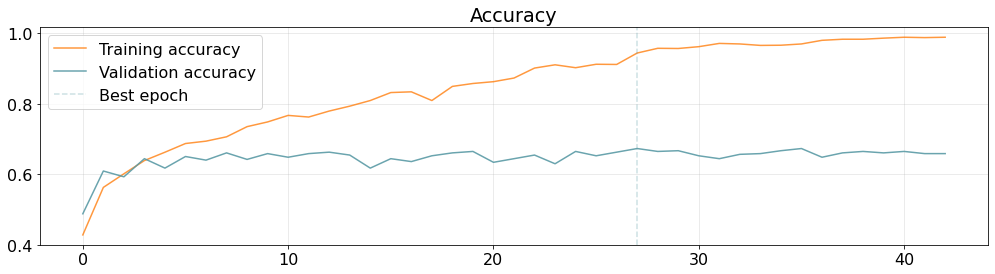

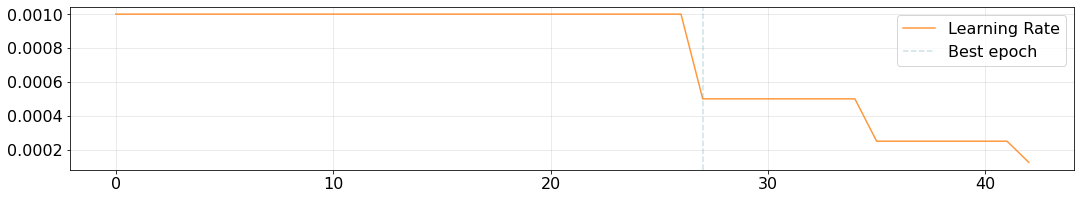

In [28]:
best_epoch = np.argmax(history1['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history1['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history1['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history1['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history1['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history1['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [29]:
epoca=np.argmax(history1['val_accuracy'])
v_acc=np.max(history1['val_accuracy'])
epoca,v_acc

(27, 0.6728395223617554)

In [30]:
model1.save('BiLSTM_attempt')

#### 1D Convolutional Neural Network

In [31]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [32]:
model2 = build_1DCNN_classifier(input_shape, classes)
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 128)           2432      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 128)           49280     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

In [33]:
# Train the model
history2 = model2.fit( 
    x = x_train_real,  
    y = y_train_real,
    batch_size = 32,
    epochs = 200,
    validation_data=(x_val_real,y_val_real),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=7, factor=0.5, min_lr=1e-6)
    ]
).history

Epoch 1/200
61/61 [==============================] - 2s 18ms/step - loss: 3.6156 - accuracy: 0.2311 - val_loss: 2.9447 - val_accuracy: 0.3765 - lr: 0.0010
Epoch 2/200
61/61 [==============================] - 1s 15ms/step - loss: 2.8355 - accuracy: 0.3567 - val_loss: 2.2989 - val_accuracy: 0.3642 - lr: 0.0010
Epoch 3/200
61/61 [==============================] - 1s 14ms/step - loss: 2.1730 - accuracy: 0.3762 - val_loss: 1.9826 - val_accuracy: 0.3848 - lr: 0.0010
Epoch 4/200
61/61 [==============================] - 1s 14ms/step - loss: 1.9723 - accuracy: 0.3984 - val_loss: 1.9690 - val_accuracy: 0.3704 - lr: 0.0010
Epoch 5/200
61/61 [==============================] - 1s 14ms/step - loss: 1.8925 - accuracy: 0.4092 - val_loss: 1.8522 - val_accuracy: 0.4383 - lr: 0.0010
Epoch 6/200
61/61 [==============================] - 1s 14ms/step - loss: 1.8555 - accuracy: 0.4231 - val_loss: 1.7504 - val_accuracy: 0.4156 - lr: 0.0010
Epoch 7/200
61/61 [==============================] - 1s 14ms/step - lo

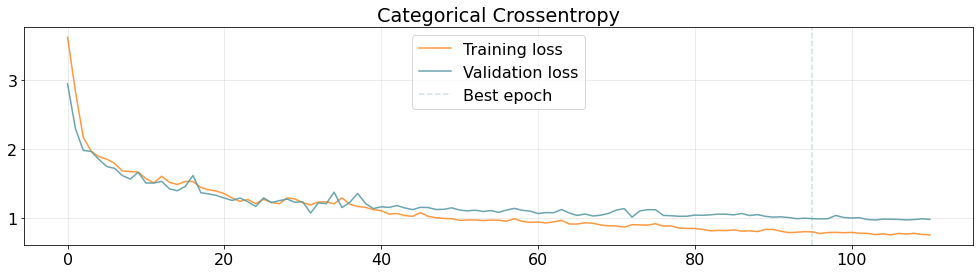

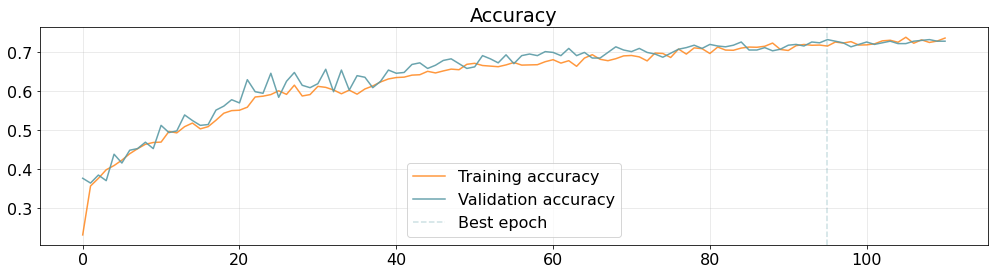

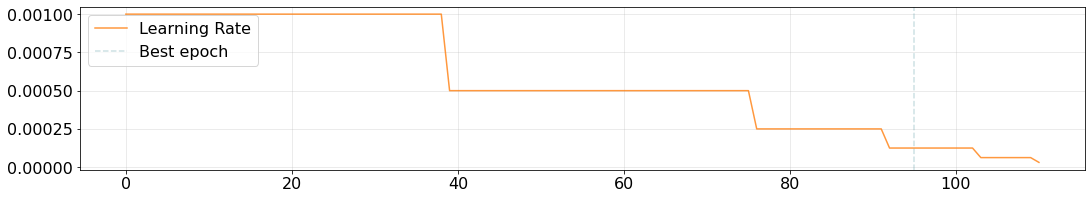

In [34]:
best_epoch = np.argmax(history2['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history2['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history2['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history2['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history2['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history2['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [36]:
epoca=np.argmax(history2['val_accuracy'])
v_acc=np.max(history2['val_accuracy'])
epoca,v_acc

(95, 0.7325102686882019)

In [35]:
model.save('1DCNN_attempt')

#### ResNet Style Model with Conv 1D, modified

In [48]:
def build_model_resnet(input_shape, nb_classes):
        n_feature_maps = 64

        input_layer = tfkl.Input(input_shape)


        x1 = tfkl.GaussianNoise(stddev=0.3)(input_layer)

        # BLOCK 1 -----------------------------------------------------------------------

        conv_x = tfkl.Conv1D(filters=n_feature_maps *2, kernel_size=5, padding='same')(x1) 
        #conv_x = tfkl.BatchNormalization()(conv_x)
        conv_x = tfkl.Activation('relu')(conv_x)

        conv_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_x)
        #conv_y = tfkl.BatchNormalization()(conv_y)
        conv_y = tfkl.Activation('relu')(conv_y)

        conv_z = tfkl.Conv1D(filters=n_feature_maps *2, kernel_size=1, padding='same')(conv_y)
        #conv_z = tfkl.BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(input_layer)
        #shortcut_y = tfkl.BatchNormalization()(shortcut_y)

        output_block_1 = tfkl.add([shortcut_y, conv_z])
        output_block_1 = tfkl.Activation('relu')(output_block_1)
        
        # BLOCK 2 ---------------------------------------------------------------------------

        conv_x = tfkl.Conv1D(filters=32, kernel_size=5, padding='same')(output_block_1)
        #conv_x = tfkl.BatchNormalization()(conv_x)
        conv_x = tfkl.Activation('relu')(conv_x)

        conv_y = tfkl.Conv1D(filters=32, kernel_size=3, padding='same')(conv_x)
        #conv_y = tfkl.BatchNormalization()(conv_y)
        conv_y = tfkl.Activation('relu')(conv_y)

        #conv_z = tfkl.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(conv_y)
        #conv_z = tfkl.BatchNormalization()(conv_z)

        # expand channels for the sum
        ##shortcut_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(output_block_1)
        #shortcut_y = tfkl.BatchNormalization()(shortcut_y)

        #output_block_2 = tfkl.add([shortcut_y, conv_z])
        output_block_2 = tfkl.Activation('relu')(conv_y)

        # BLOCK 3 ------------------------------------------------------------------------------

        conv_x = tfkl.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(output_block_2)
        #conv_x = tfkl.BatchNormalization()(conv_x)
        conv_x = tfkl.Activation('relu')(conv_x)

        conv_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x) 
        #conv_y = tfkl.BatchNormalization()(conv_y)
        conv_y = tfkl.Activation('relu')(conv_y)

        conv_z = tfkl.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
        #conv_z = tfkl.BatchNormalization()(conv_z)

        # no need to expand channels because they are equal
        #shortcut_y = tfkl.BatchNormalization()(output_block_2)

        #output_block_3 = tfkl.add([shortcut_y, conv_z])
        output_block_3 = tfkl.Activation('relu')(conv_z)

        # FINAL ---------------------------------------------------------------------------------------

        gap_layer = tfkl.GlobalAveragePooling1D()(output_block_3)
        

        dropout = tfkl.Dropout(.3, seed=seed)(gap_layer)


        output_layer = tfkl.Dense(nb_classes, activation='softmax')(dropout)
        model = tfk.Model(inputs=input_layer, outputs=output_layer)

        model.compile(loss='categorical_crossentropy' , optimizer=tfk.optimizers.Adam(),
                      metrics=['accuracy'])

        return model

In [51]:
model4 = build_model_resnet(input_shape,classes)

In [52]:
# Train the model
history4 = model4.fit( 
    x = x_train_real,  
    y = y_train_real,
    batch_size = 32,
    epochs = 200,
    validation_data=(x_val_real,y_val_real),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=7, factor=0.5, min_lr=1e-6)
    ]
).history

Epoch 1/200
61/61 [==============================] - 4s 52ms/step - loss: 2.3731 - accuracy: 0.3217 - val_loss: 2.1152 - val_accuracy: 0.3519 - lr: 0.0010
Epoch 2/200
61/61 [==============================] - 3s 47ms/step - loss: 2.0085 - accuracy: 0.3556 - val_loss: 1.8816 - val_accuracy: 0.3807 - lr: 0.0010
Epoch 3/200
61/61 [==============================] - 4s 68ms/step - loss: 1.8714 - accuracy: 0.4035 - val_loss: 1.7629 - val_accuracy: 0.4300 - lr: 0.0010
Epoch 4/200
61/61 [==============================] - 4s 61ms/step - loss: 1.7925 - accuracy: 0.4354 - val_loss: 1.7794 - val_accuracy: 0.4239 - lr: 0.0010
Epoch 5/200
61/61 [==============================] - 3s 47ms/step - loss: 1.6993 - accuracy: 0.4555 - val_loss: 1.6025 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 6/200
61/61 [==============================] - 3s 47ms/step - loss: 1.6184 - accuracy: 0.4658 - val_loss: 1.6014 - val_accuracy: 0.4671 - lr: 0.0010
Epoch 7/200
61/61 [==============================] - 3s 49ms/step - lo

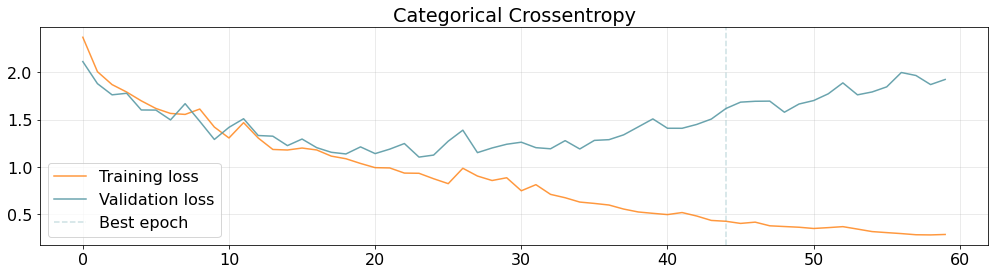

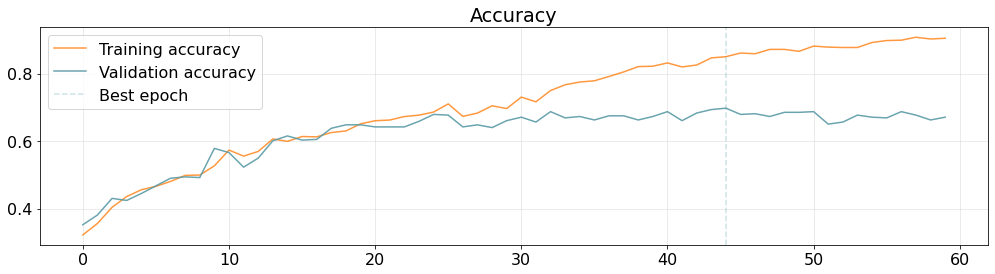

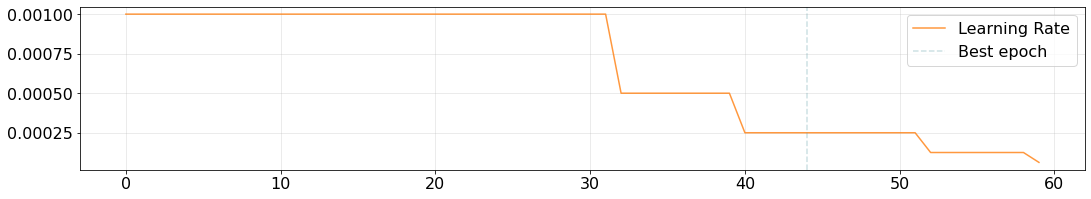

In [53]:
best_epoch = np.argmax(history4['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history4['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history4['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history4['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history4['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history4['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [54]:
epoca=np.argmax(history4['val_accuracy'])
v_acc=np.max(history4['val_accuracy'])
epoca,v_acc

(44, 0.6975308656692505)

In [55]:
model4.save('ResNetStyle_attempt')

#### ResNet Style Model with Recurrent Layers

In [56]:
def build_model_resnetrec(input_shape, nb_classes):
        n_feature_maps = 64

        input_layer = tfkl.Input(input_shape)

        # BLOCK 1
        conv_x = tfkl.LSTM(64, return_sequences=True)(input_layer)
        #conv_x = tfkl.BatchNormalization()(conv_x)
        #conv_x = tfkl.Activation('relu')(conv_x)

        conv_y=tfkl.LSTM(64, return_sequences=True)(conv_x)
        #conv_y = tfkl.BatchNormalization()(conv_y)
        #conv_y = tfkl.Activation('relu')(conv_y)

        conv_z = tfkl.LSTM(64, return_sequences=True)(conv_y)
        #conv_z = tfkl.BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = tfkl.LSTM(64, return_sequences=True)(input_layer)
        #shortcut_y = tfkl.BatchNormalization()(shortcut_y)

        output_block_1 = tfkl.add([shortcut_y, conv_z])
        output_block_1 = tfkl.Activation('relu')(output_block_1)
        

        output_block_1 = tfkl.Dropout(.5, seed=seed)(output_block_1)

        # BLOCK 2
        conv_x = tfkl.LSTM(128, return_sequences=True)(output_block_1)
        #conv_x = tfkl.BatchNormalization()(conv_x)
        #conv_x = tfkl.Activation('relu')(conv_x)

        conv_y=tfkl.LSTM(128, return_sequences=True)(conv_x)
        #conv_y = tfkl.BatchNormalization()(conv_y)
        #conv_y = tfkl.Activation('relu')(conv_y)
        
        conv_z=tfkl.LSTM(128, return_sequences=True)(conv_y)
        #conv_z = tfkl.BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = tfkl.LSTM(128, return_sequences=True)(output_block_1)
        #shortcut_y = tfkl.BatchNormalization()(shortcut_y)

        output_block_2 = tfkl.add([shortcut_y, conv_z])
        output_block_2 = tfkl.Activation('relu')(output_block_2)


        output_block_2 = tfkl.Dropout(.5, seed=seed)(output_block_2)

        # BLOCK 3
        conv_x = tfkl.LSTM(128, return_sequences=True)(output_block_2)
        #conv_x = tfkl.BatchNormalization()(conv_x)
        #conv_x = tfkl.Activation('relu')(conv_x)
        
        conv_y = tfkl.LSTM(128, return_sequences=True)(conv_x)
        #conv_y = tfkl.BatchNormalization()(conv_y)
        #conv_y = tfkl.Activation('relu')(conv_y)

        conv_z = tfkl.LSTM(128, return_sequences=True)(conv_y)
        #conv_z = tfkl.BatchNormalization()(conv_z)

        # no need to expand channels because they are equal
        #shortcut_y = tfkl.BatchNormalization()(output_block_2)

        #output_block_3 = tfkl.add([shortcut_y, conv_z])
        #output_block_3 = tfkl.Activation('relu')(output_block_3)
        

        output_block_3 = tfkl.Dropout(.5, seed=seed)(conv_y)
        
        
        # FINAL

        gap_layer = tfkl.GlobalAveragePooling1D()(output_block_3)

        classifier = tfkl.Dense(128, activation='relu')(gap_layer)
        output_layer = tfkl.Dense(nb_classes, activation='softmax')(classifier)
        #output_layer = tfkl.Dense(nb_classes, activation='softmax')(output_block_3)

        model = tfk.Model(inputs=input_layer, outputs=output_layer)

        model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(),
                      metrics=['accuracy'])

        return model

In [57]:
model5 = build_model_resnetrec(input_shape,classes)

In [58]:
# Train the model
history5 = model5.fit( 
    x = x_train_real,  
    y = y_train_real,
    batch_size = 32,
    epochs = 200,
    validation_data=(x_val_real,y_val_real),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=7, factor=0.5, min_lr=1e-6)
    ]
).history

Epoch 1/200
61/61 [==============================] - 64s 719ms/step - loss: 2.0538 - accuracy: 0.3495 - val_loss: 1.8327 - val_accuracy: 0.3992 - lr: 0.0010
Epoch 2/200
61/61 [==============================] - 29s 483ms/step - loss: 1.7572 - accuracy: 0.4128 - val_loss: 1.7159 - val_accuracy: 0.4033 - lr: 0.0010
Epoch 3/200
61/61 [==============================] - 35s 570ms/step - loss: 1.6753 - accuracy: 0.4200 - val_loss: 1.6208 - val_accuracy: 0.4383 - lr: 0.0010
Epoch 4/200
61/61 [==============================] - 40s 651ms/step - loss: 1.5736 - accuracy: 0.4447 - val_loss: 1.5391 - val_accuracy: 0.4486 - lr: 0.0010
Epoch 5/200
61/61 [==============================] - 43s 715ms/step - loss: 1.4922 - accuracy: 0.4776 - val_loss: 1.5581 - val_accuracy: 0.4383 - lr: 0.0010
Epoch 6/200
61/61 [==============================] - 36s 589ms/step - loss: 1.4666 - accuracy: 0.4853 - val_loss: 1.4829 - val_accuracy: 0.4753 - lr: 0.0010
Epoch 7/200
61/61 [==============================] - 39s 6

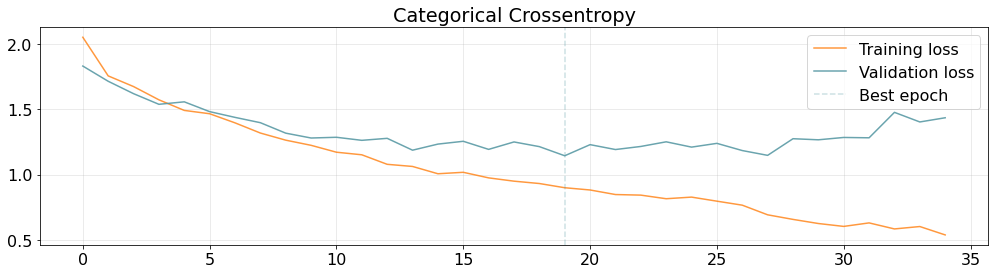

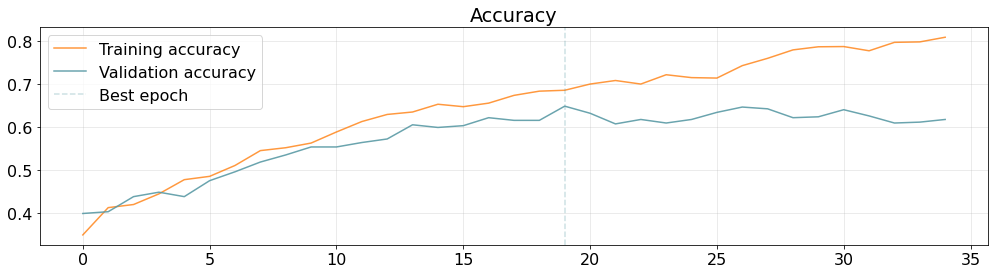

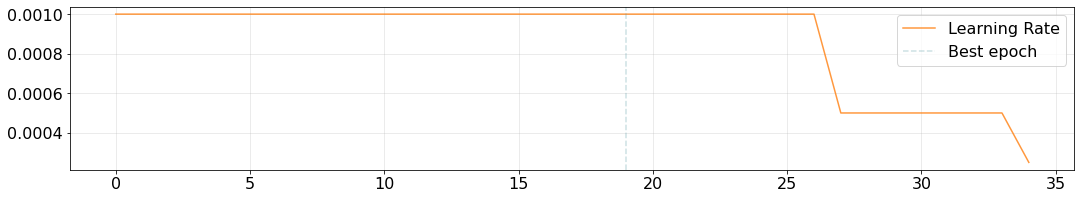

In [59]:
best_epoch = np.argmax(history5['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history5['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history5['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history5['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history5['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history5['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [60]:
epoca=np.argmax(history5['val_accuracy'])
v_acc=np.max(history5['val_accuracy'])
epoca,v_acc

(19, 0.6481481194496155)

#### ResNet & Recurrent

In [61]:
def build_model_resrec(input_shape, nb_classes):

  ##------------------------------------PRIMA PARTE---------------------------------------------------
        n_feature_maps = 64

        input_layer = tfkl.Input(input_shape)

        # BLOCK 1

        conv_x = tfkl.Conv1D(filters=n_feature_maps*2, kernel_size=8, padding='same')(input_layer)
        conv_x = tfkl.BatchNormalization()(conv_x)
        conv_x = tfkl.Activation('relu')(conv_x)

        conv_y = tfkl.Conv1D(filters=n_feature_maps*2, kernel_size=5, padding='same')(conv_x)
        conv_y = tfkl.BatchNormalization()(conv_y)
        conv_y = tfkl.Activation('relu')(conv_y)

        conv_z = tfkl.Conv1D(filters=n_feature_maps*2, kernel_size=3, padding='same')(conv_y)
        conv_z = tfkl.BatchNormalization()(conv_z)

        # expand channels for the sum
        #shortcut_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
        #shortcut_y = tfkl.BatchNormalization()(shortcut_y)

        #output_block_1 = tfkl.add([shortcut_y, conv_z])
        output_block_1 = tfkl.Activation('relu')(conv_z)

        # BLOCK 2

        # conv_x = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
        # conv_x = tfkl.BatchNormalization()(conv_x)
        # conv_x = tfkl.Activation('relu')(conv_x)

        # conv_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        # conv_y = tfkl.BatchNormalization()(conv_y)
        # conv_y = tfkl.Activation('relu')(conv_y)

        # conv_z = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        # conv_z = tfkl.BatchNormalization()(conv_z)

        # # expand channels for the sum
        # shortcut_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
        # shortcut_y = tfkl.BatchNormalization()(shortcut_y)

        # output_block_2 = tfkl.add([shortcut_y, conv_z])
        # output_block_2 = tfkl.Activation('relu')(output_block_2)

        # BLOCK 3

        # conv_x = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
        # conv_x = tfkl.BatchNormalization()(conv_x)
        # conv_x = tfkl.Activation('relu')(conv_x)

        # conv_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        # conv_y = tfkl.BatchNormalization()(conv_y)
        # conv_y = tfkl.Activation('relu')(conv_y)

        # conv_z = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        # conv_z = tfkl.BatchNormalization()(conv_z)

        # # no need to expand channels because they are equal
        # shortcut_y = tfkl.BatchNormalization()(output_block_2)

        # output_block_3 = tfkl.add([shortcut_y, conv_z])
        # output_block_3 = tfkl.Activation('relu')(output_block_3)

        # FINAL

        gap_layer = tfkl.GlobalAveragePooling1D()(output_block_1)

    ## -------------------------------------SECONDA PARTE ---------------------------------------
      # BLOCK 1
        block1=  tfkl.Permute((2, 1))(input_layer)
        #block1 = tfkl.Masking()(block1)
        block1 = tfkl.LSTM(64, return_sequences=True)(block1)
        #block1 = ut2.AttentionLSTM(64)(block1)
        block1 = tfkl.Dropout(0.3)(block1)

        #conv_x_1 = tfkl.LSTM(64, return_sequences=True)(input_layer)
        #conv_y_1=tfkl.LSTM(64, return_sequences=True)(conv_x_1)
        # conv_z_1 = tfkl.LSTM(64, return_sequences=True)(conv_y_1)

        # # expand channels for the sum
        # shortcut_y_1 = tfkl.LSTM(64, return_sequences=True)(input_layer)

        # output_block_1_1 = tfkl.add([shortcut_y_1, conv_z_1])
        # output_block_1_1 = tfkl.Activation('relu')(output_block_1_1)
        
        # #MEADDED:
        # output_block_1_1 = tfkl.Dropout(.5, seed=seed)(output_block_1_1)

        # # BLOCK 2
        # conv_x_1 = tfkl.LSTM(128, return_sequences=True)(output_block_1_1)
        # # conv_y_1=tfkl.LSTM(128, return_sequences=True)(conv_x_1)
        # conv_z_1=tfkl.LSTM(128, return_sequences=True)(conv_y_1)

        # # expand channels for the sum
        # shortcut_y_1 = tfkl.LSTM(128, return_sequences=True)(output_block_1_1)

        # output_block_2_1 = tfkl.add([shortcut_y_1, conv_z_1])
        # output_block_2_1 = tfkl.Activation('relu')(output_block_2_1)

        # #MEADDED:
        # output_block_2_1 = tfkl.Dropout(.5, seed=seed)(output_block_2_1)

        # # BLOCK 3
        # conv_x_1 = tfkl.LSTM(128, return_sequences=True)(output_block_2_1)
        # conv_y_1 = tfkl.LSTM(128, return_sequences=True)(conv_x_1)
        # conv_z_1 = tfkl.LSTM(128, return_sequences=True)(conv_y_1)

        #MEADDED:
        # output_block_3_1 = tfkl.Dropout(.5, seed=seed)(conv_y_1)
        
        # FINAL
        gap_layer_1 = tfkl.GlobalAveragePooling1D()(block1)
        #classifier_1 = tfkl.Dense(128, activation='relu')(gap_layer_1)
#----------------------------------------------------------------------

        #Merging model A and B
        a_b = tfkl.concatenate([gap_layer,gap_layer_1],name="concatenated_layer")

        output_layer = tfkl.Dense(nb_classes, activation='softmax')(a_b)

        model = tfk.Model(inputs=input_layer, outputs=output_layer)

        model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(),
                      metrics=['accuracy'])

        return model

In [62]:
model6 = build_model_resrec(input_shape,classes)

In [63]:
# Train the model
history6 = model6.fit( 
    x = x_train_real,  
    y = y_train_real,
    batch_size = 32,
    epochs = 200,
    validation_data=(x_val_real,y_val_real),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=7, factor=0.5, min_lr=1e-6)
    ]
).history

Epoch 1/200
61/61 [==============================] - 6s 53ms/step - loss: 2.0047 - accuracy: 0.3829 - val_loss: 1.8234 - val_accuracy: 0.3807 - lr: 0.0010
Epoch 2/200
61/61 [==============================] - 3s 42ms/step - loss: 1.6370 - accuracy: 0.4550 - val_loss: 1.7981 - val_accuracy: 0.3807 - lr: 0.0010
Epoch 3/200
61/61 [==============================] - 3s 43ms/step - loss: 1.4790 - accuracy: 0.4925 - val_loss: 1.8223 - val_accuracy: 0.3889 - lr: 0.0010
Epoch 4/200
61/61 [==============================] - 3s 42ms/step - loss: 1.3622 - accuracy: 0.5383 - val_loss: 1.6963 - val_accuracy: 0.4012 - lr: 0.0010
Epoch 5/200
61/61 [==============================] - 3s 41ms/step - loss: 1.2912 - accuracy: 0.5610 - val_loss: 1.4504 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/200
61/61 [==============================] - 3s 41ms/step - loss: 1.2264 - accuracy: 0.5800 - val_loss: 1.4704 - val_accuracy: 0.4815 - lr: 0.0010
Epoch 7/200
61/61 [==============================] - 2s 41ms/step - lo

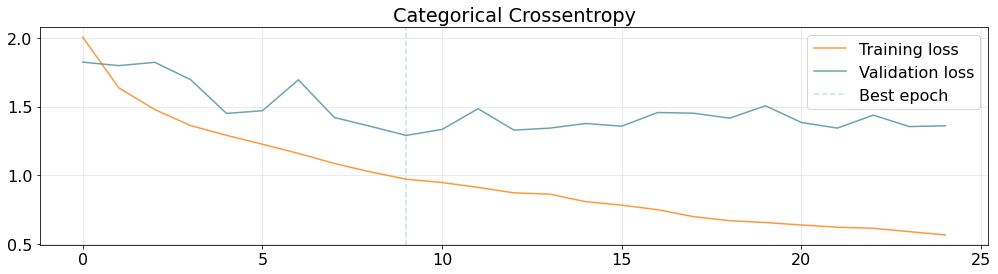

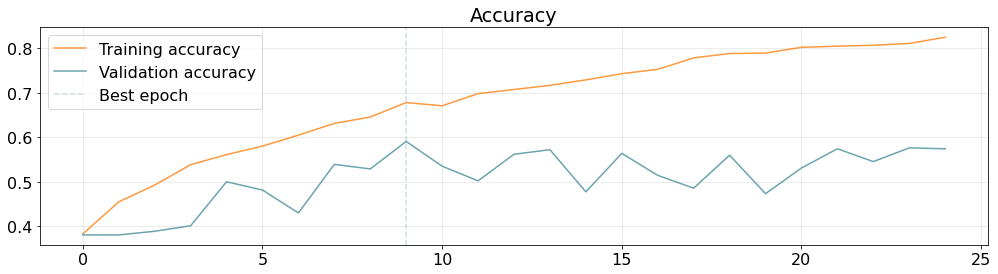

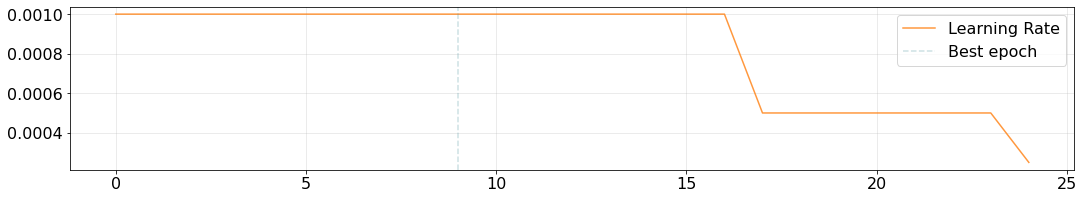

In [64]:
best_epoch = np.argmax(history6['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history6['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history6['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history6['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history6['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history6['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [65]:
epoca=np.argmax(history6['val_accuracy'])
v_acc=np.max(history6['val_accuracy'])
epoca,v_acc

(9, 0.5905349850654602)

In [66]:
model6.save('Union_attempt')

#### 1D Convolutional NN modified

In [67]:
def build_1DCNN_classifier_new(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    cnn = tfkl.GaussianNoise(stddev=0.2)(input_layer)

    # Feature extractor
    cnn = tfkl.Conv1D(128,5,padding='same',activation='relu')(cnn)
    #cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    # cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,1,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    classifier = tfkl.Dropout(.3, seed=seed)(classifier)
    output_layer = tfkl.Dense(12, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.RMSprop(learning_rate=7e-4, rho=0.9), metrics='accuracy') 

    # Return the model
    return model

In [68]:
model7 = build_1DCNN_classifier_new(input_shape,classes)

In [ ]:
#from sklearn.utils.class_weight import compute_class_weight
#y_train2=np.load('y_train.npy')
#class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train2), y= y_train2)
#class_weight = dict(zip(np.unique(y_train2), class_weights))
#class_weight

In [69]:
history7 = model7.fit( 
    x = x_train_real,  
    y = y_train_real,
    batch_size = 32,
    epochs = 200,
    #class_weight=class_weight,
    validation_data=(x_val_real,y_val_real),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=7, factor=0.5, min_lr=1e-6)
    ]
).history

Epoch 1/200
61/61 [==============================] - 3s 29ms/step - loss: 2.8390 - accuracy: 0.2795 - val_loss: 2.3073 - val_accuracy: 0.4074 - lr: 7.0000e-04
Epoch 2/200
61/61 [==============================] - 2s 25ms/step - loss: 2.2789 - accuracy: 0.3752 - val_loss: 1.9979 - val_accuracy: 0.3930 - lr: 7.0000e-04
Epoch 3/200
61/61 [==============================] - 1s 24ms/step - loss: 2.1171 - accuracy: 0.3865 - val_loss: 1.7920 - val_accuracy: 0.4362 - lr: 7.0000e-04
Epoch 4/200
61/61 [==============================] - 2s 25ms/step - loss: 1.9300 - accuracy: 0.4200 - val_loss: 1.7276 - val_accuracy: 0.4444 - lr: 7.0000e-04
Epoch 5/200
61/61 [==============================] - 1s 24ms/step - loss: 1.8247 - accuracy: 0.4400 - val_loss: 1.6210 - val_accuracy: 0.4547 - lr: 7.0000e-04
Epoch 6/200
61/61 [==============================] - 1s 24ms/step - loss: 1.7642 - accuracy: 0.4575 - val_loss: 1.5836 - val_accuracy: 0.4733 - lr: 7.0000e-04
Epoch 7/200
61/61 [===========================

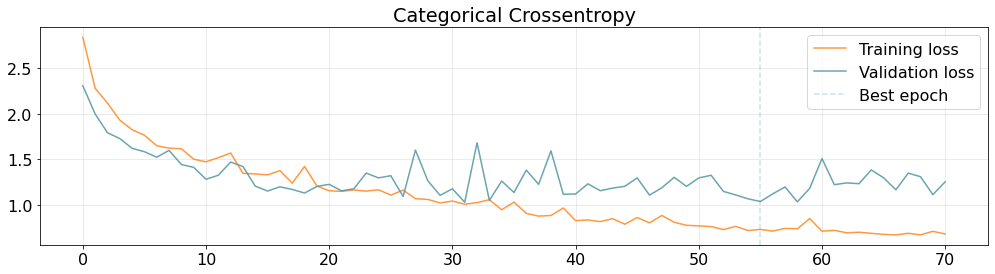

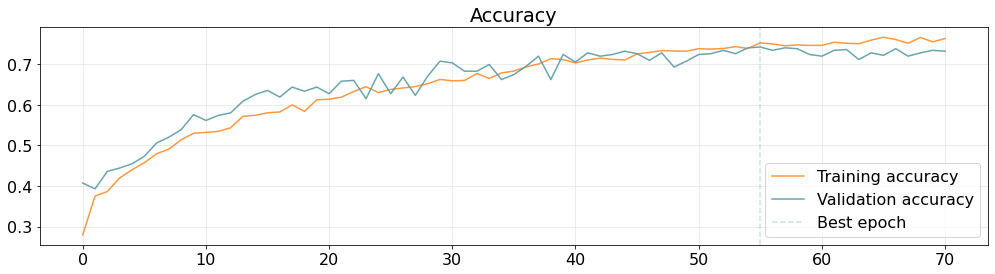

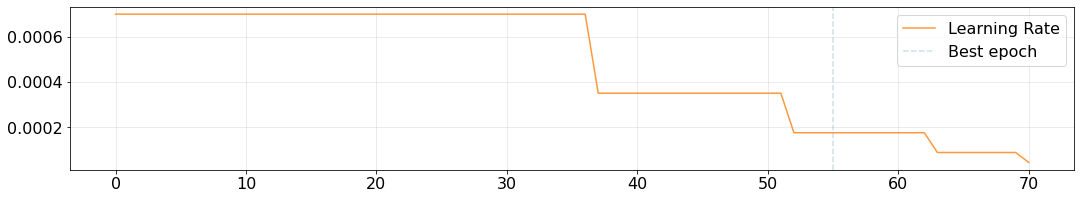

In [70]:
best_epoch = np.argmax(history7['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history7['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history7['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history7['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history7['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history7['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [71]:
epoca=np.argmax(history7['val_accuracy'])
v_acc=np.max(history7['val_accuracy'])
epoca,v_acc

(55, 0.7427983283996582)

In [72]:
model7.save('1DConv_RMS_attempt')

#### 1D CNN concatenate

In [73]:
 def build_1DCNN_classifier_union(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
 ## ----------------------------------- PRIMA PARTE ------------------------------------------
    cnn = tfkl.GaussianNoise(stddev=0.2)(input_layer)

    # Feature extractor
    cnn = tfkl.Conv1D(128,5,padding='same',activation='relu')(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.Conv1D(128,1,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(gap)

 ## ------------------------------------- SECONDA PARTE ---------------------------------------

    cnn1 = tfkl.GaussianNoise(stddev=0.3)(input_layer)

    cn11 = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(cnn1)

    # Feature extractor
    gap1 = tfkl.GlobalAveragePooling1D()(cnn1)
    dropout1 = tfkl.Dropout(.3, seed=seed)(gap1) 
    
    # Classifier
    classifier1 = tfkl.Dense(64, activation='relu')(gap1)
#----------------------------------------------------------------------
    #Merging model A and B
    a_b = tfkl.concatenate([classifier,classifier1],name="concatenated_layer")

    output_layer = tfkl.Dense(12, activation='softmax')(a_b)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [74]:
model8 = build_1DCNN_classifier_union(input_shape,classes)

In [75]:
# Train the model
history8 = model8.fit(
    x = x_train_real,
    y = y_train_real,
    batch_size = 32,
    epochs = 200,
    validation_data=(x_val_real,y_val_real),
    #class_weight=class_weight,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
61/61 [==============================] - 3s 38ms/step - loss: 2.8899 - accuracy: 0.2980 - val_loss: 2.3365 - val_accuracy: 0.4156 - lr: 0.0010
Epoch 2/200
61/61 [==============================] - 2s 34ms/step - loss: 2.1624 - accuracy: 0.4040 - val_loss: 2.1010 - val_accuracy: 0.4300 - lr: 0.0010
Epoch 3/200
61/61 [==============================] - 2s 33ms/step - loss: 1.9038 - accuracy: 0.4236 - val_loss: 1.8012 - val_accuracy: 0.4239 - lr: 0.0010
Epoch 4/200
61/61 [==============================] - 2s 33ms/step - loss: 1.6673 - accuracy: 0.4493 - val_loss: 1.8710 - val_accuracy: 0.4321 - lr: 0.0010
Epoch 5/200
61/61 [==============================] - 2s 33ms/step - loss: 1.6549 - accuracy: 0.4673 - val_loss: 1.6762 - val_accuracy: 0.4733 - lr: 0.0010
Epoch 6/200
61/61 [==============================] - 2s 34ms/step - loss: 1.4865 - accuracy: 0.5090 - val_loss: 1.5385 - val_accuracy: 0.5185 - lr: 0.0010
Epoch 7/200
61/61 [==============================] - 2s 34ms/step - lo

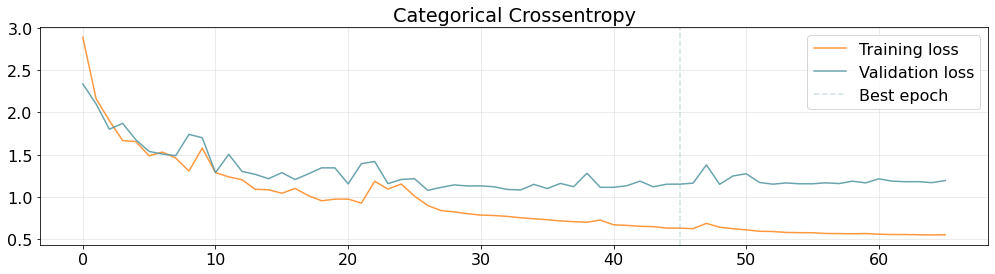

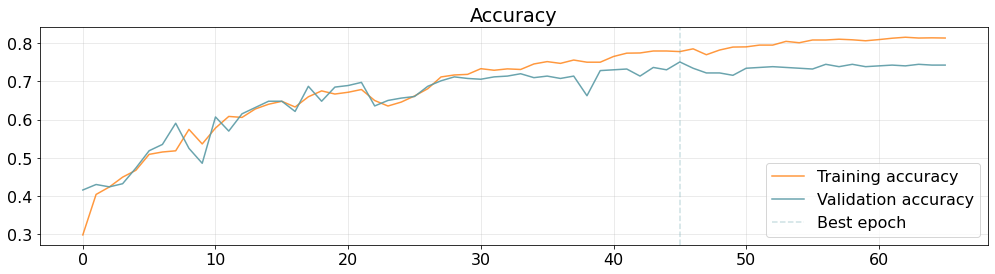

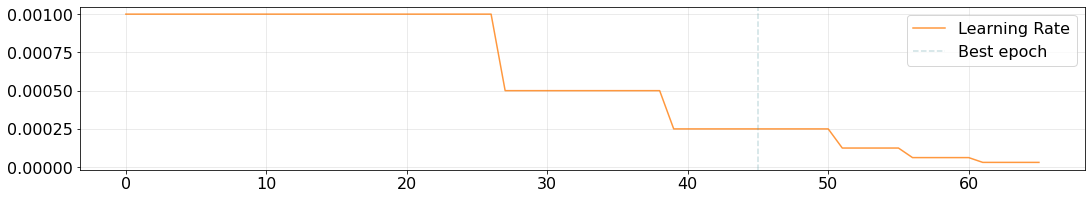

In [76]:
best_epoch = np.argmax(history8['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history8['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history8['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history8['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history8['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history8['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [77]:
epoca=np.argmax(history8['val_accuracy'])
v_acc=np.max(history8['val_accuracy'])
epoca,v_acc

(45, 0.751028835773468)

In [78]:
model8.save('1DCNN_concatenate_attempt')

#### 1D CNN & Recurrent

In [79]:
 def build_1DCNN_classifier_union2(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    cnn = tfkl.GaussianNoise(stddev=0.2)(input_layer)

    # Feature extractor
    cnn = tfkl.Conv1D(128,6,padding='same',activation='relu')(cnn)
    # cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    # cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,1,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    #Forse aggiungere Dense 12:
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(gap)
  

 ## -------------------------------------SECONDA PARTE ---------------------------------------

    cnn1 = tfkl.GaussianNoise(stddev=0.2)(input_layer) 

    # Feature extractor
    cnn1 = tfkl.Conv1D(128,6,padding='same',activation='relu')(cnn1) 
    # cnn = tfkl.MaxPooling1D()(cnn)
    cnn1 = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn1) 
    # cnn = tfkl.MaxPooling1D()(cnn)
    cnn1 = tfkl.Conv1D(128,1,padding='same',activation='relu')(cnn1)
    gap1 = tfkl.GlobalAveragePooling1D()(cnn1)
    #Forse aggiungere Dense 12:
    dropout1 = tfkl.Dropout(.3, seed=seed)(gap1) 

    # Classifier
    classifier1 = tfkl.Dense(64, activation='relu')(gap1)
#----------------------------------------------------------------------
    #Merging model A and B
    a_b = tfkl.concatenate([classifier,classifier1],name="concatenated_layer")

    output_layer = tfkl.Dense(12, activation='softmax')(a_b)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [80]:
model9 = build_1DCNN_classifier_union2(input_shape,classes)

In [81]:
# Train the model
history9 = model9.fit(
    x = x_train_real,
    y = y_train_real,
    batch_size = 32,
    epochs = 200,
    validation_data=(x_val_real,y_val_real),
    #class_weight=class_weight,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
61/61 [==============================] - 4s 42ms/step - loss: 2.6351 - accuracy: 0.3191 - val_loss: 2.2783 - val_accuracy: 0.3786 - lr: 0.0010
Epoch 2/200
61/61 [==============================] - 2s 38ms/step - loss: 2.0440 - accuracy: 0.4035 - val_loss: 2.0043 - val_accuracy: 0.3971 - lr: 0.0010
Epoch 3/200
61/61 [==============================] - 4s 58ms/step - loss: 1.8521 - accuracy: 0.4251 - val_loss: 1.9900 - val_accuracy: 0.4198 - lr: 0.0010
Epoch 4/200
61/61 [==============================] - 3s 55ms/step - loss: 1.7576 - accuracy: 0.4663 - val_loss: 1.8387 - val_accuracy: 0.4630 - lr: 0.0010
Epoch 5/200
61/61 [==============================] - 2s 37ms/step - loss: 1.7287 - accuracy: 0.4766 - val_loss: 1.6509 - val_accuracy: 0.4835 - lr: 0.0010
Epoch 6/200
61/61 [==============================] - 2s 37ms/step - loss: 1.4658 - accuracy: 0.5100 - val_loss: 1.4853 - val_accuracy: 0.5617 - lr: 0.0010
Epoch 7/200
61/61 [==============================] - 2s 37ms/step - lo

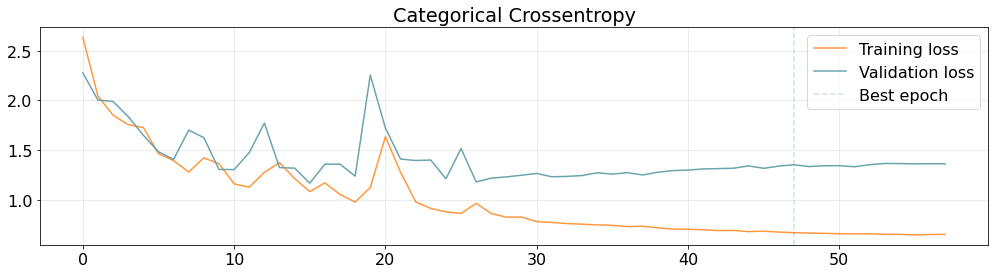

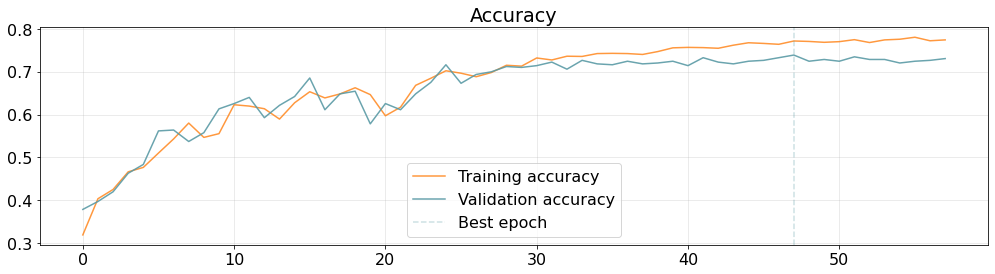

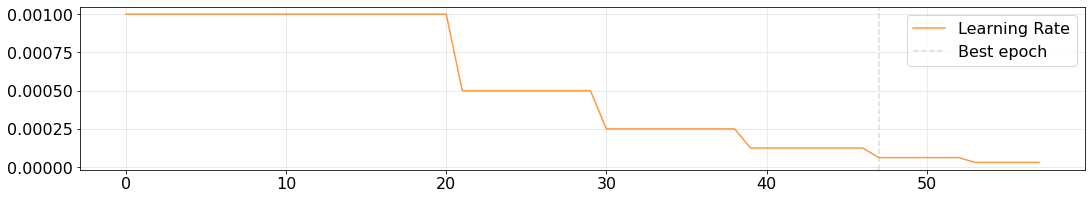

In [82]:
best_epoch = np.argmax(history9['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history9['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history9['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history9['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history9['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history9['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [83]:
epoca=np.argmax(history9['val_accuracy'])
v_acc=np.max(history9['val_accuracy'])
epoca,v_acc

(47, 0.7386831045150757)

#### Transformer Model:

In [84]:
!pip install transformers
from transformers import pipeline
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.0 MB/s 
     |████████████████████████████████| 182 kB 60.6 MB/s 
     |████████████████████████████████| 7.6 MB 54.0 MB/s 


In [89]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    #x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    #x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_model_transformer(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    cnn = tfkl.GaussianNoise(stddev=0.2)(x)

    # Feature extractor
    cnn = tfkl.Conv1D(128,5,padding='same',activation='relu')(cnn)
    #cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    # cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,1,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    classifier = tfkl.Dropout(.3, seed=seed)(classifier)
    outputs = tfkl.Dense(12, activation='softmax')(classifier)

    #x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    # for dim in mlp_units:
    #     x = layers.Dense(dim, activation="relu")(x)
    #     x = layers.Dropout(mlp_dropout)(x)
    # outputs = layers.Dense(12, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [90]:
model10 = build_model_transformer(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=2,
    mlp_units=[128],
    mlp_dropout=0.3, 
    dropout=0.25,
)

model10.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.RMSprop(learning_rate=7e-4, rho=0.9), metrics='accuracy')

model10.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 multi_head_attention_2 (MultiH  (None, 36, 6)       27654       ['input_8[0][0]',                
 eadAttention)                                                    'input_8[0][0]']                
                                                                                                  
 dropout_27 (Dropout)           (None, 36, 6)        0           ['multi_head_attention_2[0][0]'] 
                                                                                                  
 conv1d_48 (Conv1D)             (None, 36, 128)      896         ['dropout_27[0][0]']       

In [91]:
history10 = model10.fit( 
    x = x_train_real,  
    y = y_train_real,
    batch_size = 32,
    epochs = 200,
    validation_data=(x_val_real,y_val_real),
    #class_weight=class_weight,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True), 
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=7, factor=0.5, min_lr=1e-6)
    ]
).history

Epoch 1/200
61/61 [==============================] - 17s 235ms/step - loss: 2.9311 - accuracy: 0.2790 - val_loss: 2.4074 - val_accuracy: 0.3498 - lr: 7.0000e-04
Epoch 2/200
61/61 [==============================] - 14s 228ms/step - loss: 2.3258 - accuracy: 0.3525 - val_loss: 2.2438 - val_accuracy: 0.3765 - lr: 7.0000e-04
Epoch 3/200
61/61 [==============================] - 14s 229ms/step - loss: 2.1907 - accuracy: 0.3819 - val_loss: 1.8646 - val_accuracy: 0.4259 - lr: 7.0000e-04
Epoch 4/200
61/61 [==============================] - 14s 228ms/step - loss: 2.0078 - accuracy: 0.4061 - val_loss: 1.9337 - val_accuracy: 0.4506 - lr: 7.0000e-04
Epoch 5/200
61/61 [==============================] - 16s 268ms/step - loss: 1.9305 - accuracy: 0.4225 - val_loss: 1.7165 - val_accuracy: 0.4547 - lr: 7.0000e-04
Epoch 6/200
61/61 [==============================] - 14s 229ms/step - loss: 1.7987 - accuracy: 0.4442 - val_loss: 1.8392 - val_accuracy: 0.4568 - lr: 7.0000e-04
Epoch 7/200
61/61 [===============

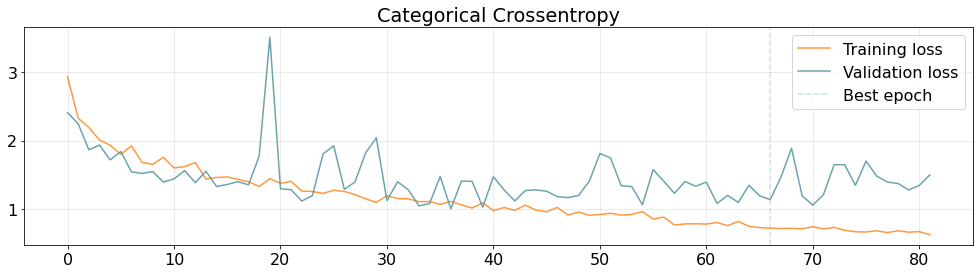

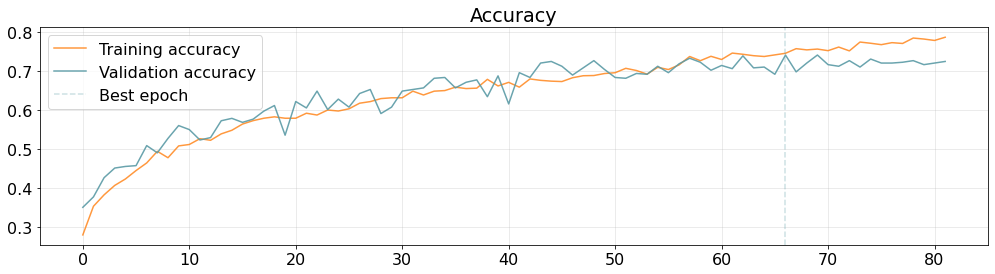

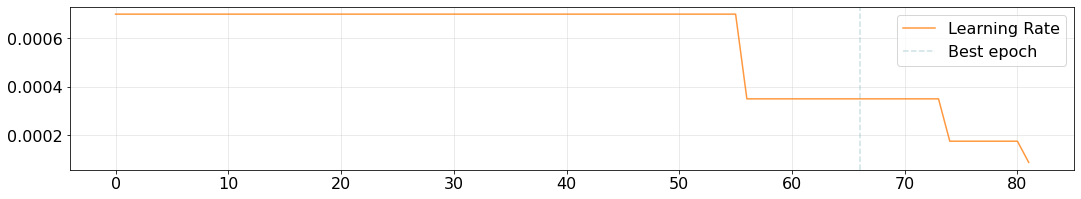

In [92]:
best_epoch = np.argmax(history10['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history10['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history10['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history10['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history10['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history10['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [93]:
epoca=np.argmax(history10['val_accuracy'])
v_acc=np.max(history10['val_accuracy'])
epoca,v_acc

(66, 0.7407407164573669)

In [94]:
model10.save('Transformer_attempt')

### Ensemble of the best models

At the end we tried ensembling our best models to improve our results:

In [ ]:
!pip show imblearn

Name: imblearn
Version: 0.0
Summary: Toolbox for imbalanced dataset in machine learning.
Home-page: https://pypi.python.org/pypi/imbalanced-learn/
Author: UNKNOWN
Author-email: UNKNOWN
License: UNKNOWN
Location: /usr/local/lib/python3.8/dist-packages
Requires: imbalanced-learn
Required-by: 


In [97]:
model_1 = tfk.models.load_model("1DConv_RMS_attempt")
model_2 = tfk.models.load_model("FCN")
model_3=tfk.models.load_model("Transformer_attempt")

In [106]:
def ensembleModels(models, model_input):
    yModels=[model(model_input) for model in models] 

    # averaging outputs
    yAvg=tfk.layers.average(yModels)

    # build model from same input and avg output
    modelEns = tfk.Model(inputs=model_input, outputs=yAvg, name='ensemble')  
   
    return modelEns

In [107]:
models=[model_1, model_2, model_3]

In [108]:
model_input=tfk.Input(shape=models[0].input_shape[1:])
modelEns=ensembleModels(models,model_input)
modelEns.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=7e-4, rho=0.9), loss=tfk.losses.CategoricalCrossentropy(), metrics='accuracy')
modelEns.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 36, 6)]      0           []                               
                                                                                                  
 model (Functional)             (None, 12)           87820       ['input_10[0][0]']               
                                                                                                  
 model_1 (Functional)           (None, 12)           179532      ['input_10[0][0]']               
                                                                                                  
 model_15 (Functional)          (None, 12)           146468      ['input_10[0][0]']               
                                                                                           

In [109]:
modelEns.evaluate(x_val_real,y_val_real, return_dict=True)

16/16 [==============================] - 5s 139ms/step - loss: 0.5858 - accuracy: 0.8107


{'loss': 0.5858004689216614, 'accuracy': 0.8106995820999146}

In [101]:
# Train the model
historyEns = modelEns.fit( 
    x = x_train_real,  
    y = y_train_real,
    batch_size = 32,
    epochs = 200,
    validation_data=(x_val_real,y_val_real),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True), 
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=7, factor=0.5, min_lr=1e-6)
    ]
).history

Epoch 1/200
61/61 [==============================] - 23s 283ms/step - loss: 0.6393 - accuracy: 0.7880 - val_loss: 0.5858 - val_accuracy: 0.8107 - lr: 7.0000e-04
Epoch 2/200
61/61 [==============================] - 17s 275ms/step - loss: 0.6399 - accuracy: 0.7838 - val_loss: 0.6056 - val_accuracy: 0.8025 - lr: 7.0000e-04
Epoch 3/200
61/61 [==============================] - 17s 273ms/step - loss: 0.6150 - accuracy: 0.7931 - val_loss: 0.6364 - val_accuracy: 0.7942 - lr: 7.0000e-04
Epoch 4/200
61/61 [==============================] - 19s 315ms/step - loss: 0.6199 - accuracy: 0.7895 - val_loss: 0.6064 - val_accuracy: 0.7901 - lr: 7.0000e-04
Epoch 5/200
61/61 [==============================] - 17s 276ms/step - loss: 0.5788 - accuracy: 0.8029 - val_loss: 0.5803 - val_accuracy: 0.7963 - lr: 7.0000e-04
Epoch 6/200
61/61 [==============================] - 17s 276ms/step - loss: 0.5702 - accuracy: 0.8096 - val_loss: 0.6125 - val_accuracy: 0.7901 - lr: 7.0000e-04
Epoch 7/200
61/61 [===============

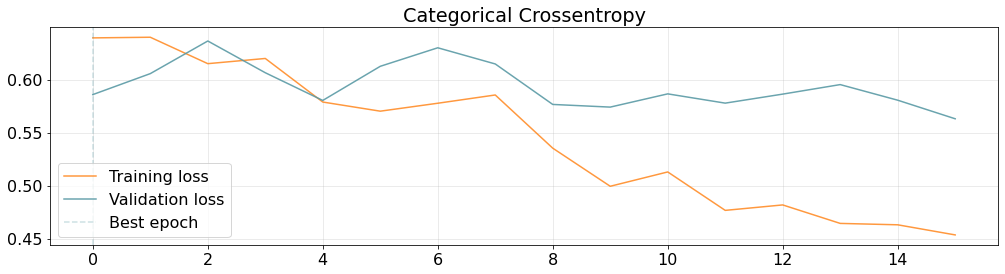

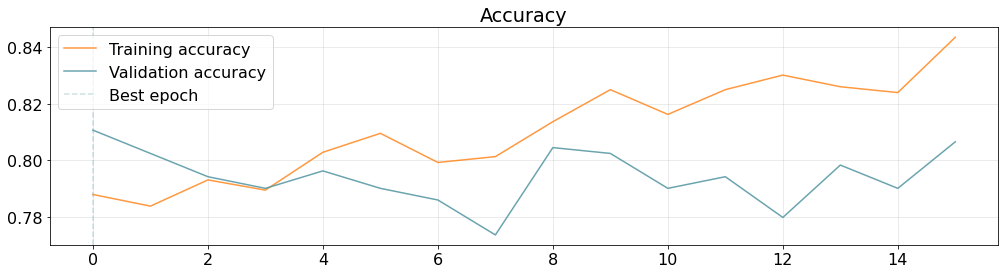

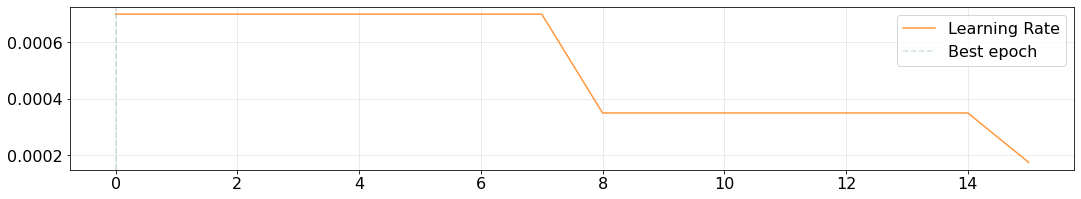

In [104]:
best_epoch = np.argmax(historyEns['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(historyEns['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(historyEns['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(historyEns['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(historyEns['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(historyEns['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [105]:
epoca=np.argmax(historyEns['val_accuracy'])
v_acc=np.max(historyEns['val_accuracy'])
epoca,v_acc

(0, 0.8106995820999146)

In [118]:
modelEns.save('Ensemble_final')